In [1]:
%pwd

'/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks'

In [237]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
import sys, os
import numpy as np
import torch
import matplotlib.pyplot as plt

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

In [371]:
%autoreload

wave_file = '../data/wave_sim/steady_state_wave.npy'
wave_image = mre_pinn.data.ImagePointSet(wave_file, resolution=0.005)

elast_file = '../data/wave_sim/elasticity.npy'
elast_image = mre_pinn.data.ImagePointSet(elast_file, resolution=0.005)

x = wave_image.points
x_scale = np.std(x, axis=0)

u = wave_image.values.cpu().numpy()
u = np.stack([u[:,0].real, u[:,0].imag, u[:,1].real, u[:,1].imag], axis=1)
u_loc = np.mean(u, axis=0)
u_scale = np.std(u, axis=0)

mu = elast_image.values.cpu().numpy()
mu = np.stack([mu.real, mu.imag], axis=1)
mu_loc = np.mean(mu, axis=0)
mu_scale = np.std(mu, axis=0)

x_scale.shape, u_loc.shape, u_scale.shape, mu_loc.shape, mu_scale.shape

((2,), (4,), (4,), (2,), (2,))

In [633]:
pde = mre_pinn.pde.HelmholtzPDE(rho=1.0, omega=10*(2*np.pi))

geometry = deepxde.geometry.Rectangle([-0.5, -0.5], [0.5, 0.5])
data = deepxde.data.PDE(
    geometry=geometry,
    pde=pde,
    bcs=[wave_image],
    anchors=wave_image.points,
    num_domain=0,
    num_test=None
)

In [655]:
%autoreload

net = mre_pinn.model.Parallel([
    mre_pinn.model.ComplexFFN(
        n_input=2,
        n_layers=5,
        n_hidden=16,
        n_output=n_output,
        activ_fn=torch.sin,
        w0=32
    ) for n_output in [2, 1] # u and mu
])
net[0].init_weights(input_scale=1, output_scale=u_scale, output_loc=u_loc)
net[1].init_weights(input_scale=x_scale, output_scale=mu_scale, output_loc=mu_loc)

net

Parallel(
  (0): ComplexFFN(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
  (1): ComplexFFN(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [656]:
def msae_loss(y_true, y_pred):
    '''
    Mean squared absolute error.
    '''
    return torch.mean(torch.abs(y_true - y_pred)**2)

model = deepxde.Model(data, net)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss=msae_loss,
    loss_weights=[0, 1]
)

Compiling model...
'compile' took 0.000345 s



In [657]:
w_max = 0.0001

import matplotlib as mpl

class TrainingPlot(deepxde.display.TrainingDisplay):
    
    def __init__(self):
        self.initialized = False
    
    def initialize(self):
        self.fig, self.axes = plt.subplots(1, 2, figsize=(8,4), squeeze=False)
        labels = ['PDE loss', 'data loss']
        self.lines = [self.axes[0,0].plot([], [], label=labels[i])[0] for i in range(2)]
        self.scatter = self.axes[0,1].scatter([], [], marker='o', s=0.2, cmap=w_map, vmin=-w_max, vmax=w_max)
        self.axes[0,0].legend(frameon=False)
        self.axes[0,0].set_yscale('log')
        self.axes[0,0].grid(color='gray', linestyle=':')
        self.axes[0,1].set_xlim(-0.5, 0.5)
        self.axes[0,1].set_ylim(-0.5, 0.5)
        self.initialized = True

    def __call__(self, train_state):

        if not self.initialized:
            self.initialize()
        
        for i, line in enumerate(self.lines):
            new_x = train_state.step
            new_y = train_state.loss_train[i]
            line.set_xdata(np.append(line.get_xdata(), new_x))
            line.set_ydata(np.append(line.get_ydata(), new_y))
            
        if (train_state.step % 10) == 0:
            x = train_state.X_train
            ux = train_state.y_pred_train[:,0]
            uy = train_state.y_pred_train[:,1]
            mu = train_state.y_pred_train[:,2]

            self.scatter.set_offsets(x)
            w_min = np.min(ux.real)
            w_max = np.max(ux.real)
            w_max = max(abs(w_min), abs(w_max))
            n = mpl.colors.Normalize(vmin=-w_max, vmax=w_max)
            m = mpl.cm.ScalarMappable(norm=n, cmap=w_map)
            self.scatter.set_facecolor(m.to_rgba(ux.real))
            
        self.axes[0,0].relim()
        self.axes[0,0].autoscale_view()
    
        self.fig.canvas.draw()

Training model...



<IPython.core.display.Javascript object>


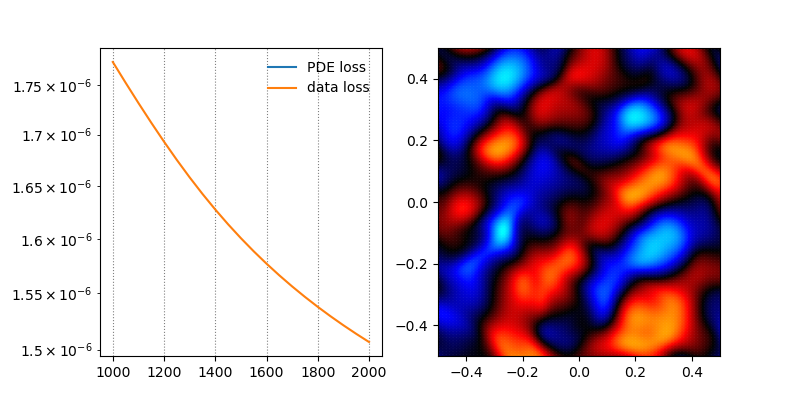


Best model at step 2000:
  train loss: 1.51e-06
  test loss: 1.51e-06
  test metric: []

'train' took 47.665747 s



In [659]:
deepxde.display.training_display = TrainingPlot()
try:
    model.train(1000, display_every=50)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [660]:
outputs = model.predict(wave_image.points)
outputs.shape, outputs.dtype

((40401, 3), dtype('complex64'))

<IPython.core.display.Javascript object>


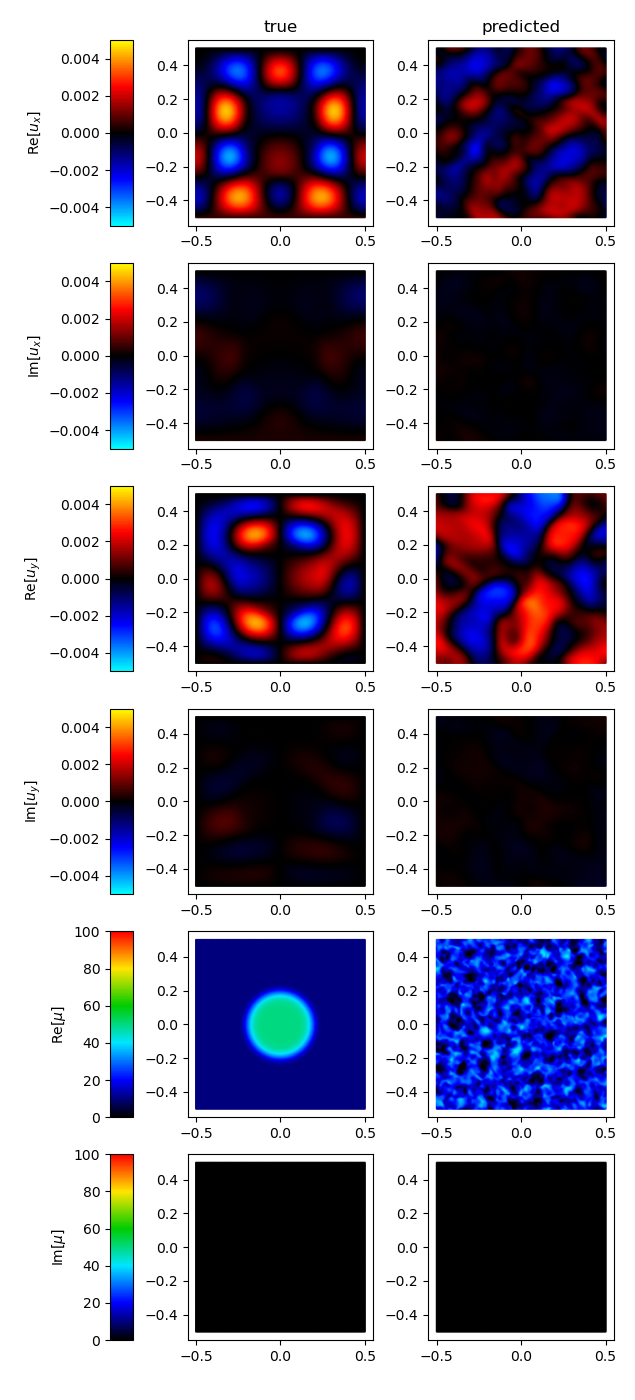

In [661]:
def plot_image_2d(a, dims, ax, **kwargs):
    extent = (0, dims[0], 0, dims[1])
    im = ax.imshow(a, extent=extent, resample=False, **kwargs)
    #ax.set_xlabel('x')
    #ax.set_ylabel('y')
    return im


def plot_points_2d(x, u, dims, ax, **kwargs):
    sc = ax.scatter(x[:,0], x[:,1], c=u, marker='o', s=0.2, **kwargs)
    ax.set_aspect(dims[1] / dims[0])
    #ax.set_xlabel('x')
    #ax.set_ylabel('y')
    return sc


def plot_colorbar(obj, label, ax):
    plt.colorbar(obj, cax=ax)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
    ax.set_ylabel(label)

w_map = mre_pinn.visual.wave_color_map()
w_max = 0.005
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

e_map = mre_pinn.visual.elast_color_map()
e_max = 100
elast_kws = dict(cmap=e_map, vmin=0, vmax=e_max)

x = wave_image.points
ux_true = wave_image.values[:,0].cpu().numpy()
uy_true = wave_image.values[:,1].cpu().numpy()
mu_true = elast_image.values.cpu().numpy()

ux_pred = outputs[:,0]
uy_pred = outputs[:,1]
mu_pred = outputs[:,2]

# configure plot grid
n_rows = 6
n_cols = 3
size = 2
hspace = 0.2
wspace = 0.4
lpad = 1.1
rpad = 0.2
bpad = 0.6
tpad = 0.4
fig_height = n_rows * size + (n_rows - 1) * hspace + bpad + tpad
fig_width = (n_cols - 1) * (size + wspace) + size/8 + lpad + rpad
fig, axes = plt.subplots(
    n_rows, n_cols, squeeze=False,
    figsize=(fig_width, fig_height),
    gridspec_kw=dict(
        width_ratios=[1/8,1,1],
        hspace=hspace, wspace=wspace,
        left=lpad/fig_width, right=1 - rpad/fig_width,
        bottom=bpad/fig_height, top=1 - tpad/fig_height
    )
)

# header labels
axes[0,1].set_title('true')
axes[0,2].set_title('predicted')

# plot colorbar, true, and predicted for each variable
sc = plot_points_2d(x, ux_true.real, [1, 1], ax=axes[0,1], **wave_kws)
sc = plot_points_2d(x, ux_pred.real, [1, 1], ax=axes[0,2], **wave_kws)
plot_colorbar(sc, ax=axes[0,0], label='Re[$u_x$]')

sc = plot_points_2d(x, ux_true.imag, [1, 1], ax=axes[1,1], **wave_kws)
sc = plot_points_2d(x, ux_pred.imag, [1, 1], ax=axes[1,2], **wave_kws)
plot_colorbar(sc, ax=axes[1,0], label='Im[$u_x$]')

sc = plot_points_2d(x, uy_true.real, [1, 1], ax=axes[2,1], **wave_kws)
sc = plot_points_2d(x, uy_pred.real, [1, 1], ax=axes[2,2], **wave_kws)
plot_colorbar(sc, ax=axes[2,0], label='Re[$u_y$]')

sc = plot_points_2d(x, uy_true.imag, [1, 1], ax=axes[3,1], **wave_kws)
sc = plot_points_2d(x, uy_pred.imag, [1, 1], ax=axes[3,2], **wave_kws)
plot_colorbar(sc, ax=axes[3,0], label='Im[$u_y$]')

sc = plot_points_2d(x, mu_true.real, [1, 1], ax=axes[4,1], **elast_kws)
sc = plot_points_2d(x, mu_pred.real, [1, 1], ax=axes[4,2], **elast_kws)
plot_colorbar(sc, ax=axes[4,0], label='Re[$\mu$]')

sc = plot_points_2d(x, mu_true.imag, [1, 1], ax=axes[5,1], **elast_kws)
sc = plot_points_2d(x, mu_pred.imag, [1, 1], ax=axes[5,2], **elast_kws)
plot_colorbar(sc, ax=axes[5,0], label='Im[$\mu$]')